In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048, 512)
        self.z_log_var = nn.Linear(2048, 512)

        self.decoder = nn.Sequential(
            nn.Linear(512, 2048),
            nn.Unflatten(1, (2048, 1, 1)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=(-1, 1), translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=128, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
704 704 704


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 200

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:16<00:00, 43.72it/s]


Epoch: 0 - TrainRecLoss: 2304.908869483254 - ValidRecLoss: 1721.693875919689
Epoch: 0 - TrainDivLoss: 164.55277163332158 - ValidDivLoss: 82.12043968113986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.28it/s]


Epoch: 1 - TrainRecLoss: 1636.4087080522017 - ValidRecLoss: 1580.6510018435392
Epoch: 1 - TrainDivLoss: 69.39490614154123 - ValidDivLoss: 60.40728770060973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.81it/s]


Epoch: 2 - TrainRecLoss: 1507.254432851618 - ValidRecLoss: 1438.5927078940651
Epoch: 2 - TrainDivLoss: 55.42566951296546 - ValidDivLoss: 54.140709275549106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.03it/s]


Epoch: 3 - TrainRecLoss: 1412.189976085316 - ValidRecLoss: 1529.2612057599154
Epoch: 3 - TrainDivLoss: 57.275308869101785 - ValidDivLoss: 60.38836467266083


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.73it/s]


Epoch: 4 - TrainRecLoss: 1384.3563022613525 - ValidRecLoss: 1338.782398223877
Epoch: 4 - TrainDivLoss: 59.14672751860185 - ValidDivLoss: 54.5167486613447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.26it/s]


Epoch: 5 - TrainRecLoss: 1338.2046189741654 - ValidRecLoss: 1315.3346004486084
Epoch: 5 - TrainDivLoss: 52.86650396477092 - ValidDivLoss: 53.827082043344326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.91it/s]


Epoch: 6 - TrainRecLoss: 1323.3263123252175 - ValidRecLoss: 1297.5428613315928
Epoch: 6 - TrainDivLoss: 50.54167499325492 - ValidDivLoss: 51.04859095269983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.18it/s]


Epoch: 7 - TrainRecLoss: 1299.841927615079 - ValidRecLoss: 1273.6278217489069
Epoch: 7 - TrainDivLoss: 50.349015479738064 - ValidDivLoss: 50.70220759240064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.78it/s]


Epoch: 8 - TrainRecLoss: 1277.7865366502242 - ValidRecLoss: 1259.8077653538096
Epoch: 8 - TrainDivLoss: 51.18651341850107 - ValidDivLoss: 54.27077616886659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.36it/s]


Epoch: 9 - TrainRecLoss: 1259.4186567826705 - ValidRecLoss: 1241.4572878750887
Epoch: 9 - TrainDivLoss: 52.57199187170375 - ValidDivLoss: 52.73567786541852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.44it/s]


Epoch: 10 - TrainRecLoss: 1244.9863787564364 - ValidRecLoss: 1212.4982352690263
Epoch: 10 - TrainDivLoss: 52.23319781910289 - ValidDivLoss: 52.44292097200047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.31it/s]


Epoch: 11 - TrainRecLoss: 1225.0699839158492 - ValidRecLoss: 1206.283626903187
Epoch: 11 - TrainDivLoss: 52.47979629581625 - ValidDivLoss: 53.71793070164594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.49it/s]


Epoch: 12 - TrainRecLoss: 1208.9930008974943 - ValidRecLoss: 1193.5541058453646
Epoch: 12 - TrainDivLoss: 53.294897805560716 - ValidDivLoss: 54.639787473461844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.30it/s]


Epoch: 13 - TrainRecLoss: 1192.8870107477362 - ValidRecLoss: 1179.2599829760466
Epoch: 13 - TrainDivLoss: 53.17276510867205 - ValidDivLoss: 54.4183838150718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.70it/s]


Epoch: 14 - TrainRecLoss: 1180.3784223036332 - ValidRecLoss: 1154.4845245534723
Epoch: 14 - TrainDivLoss: 54.20552343671972 - ValidDivLoss: 53.323077754540876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.22it/s]


Epoch: 15 - TrainRecLoss: 1171.5828956257212 - ValidRecLoss: 1161.3478484587235
Epoch: 15 - TrainDivLoss: 54.18209377743981 - ValidDivLoss: 54.428518652915955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.30it/s]


Epoch: 16 - TrainRecLoss: 1167.32174058394 - ValidRecLoss: 1149.4467606977983
Epoch: 16 - TrainDivLoss: 55.36917697299611 - ValidDivLoss: 54.61813724582846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.75it/s]


Epoch: 17 - TrainRecLoss: 1155.6970451528375 - ValidRecLoss: 1145.1243782043457
Epoch: 17 - TrainDivLoss: 55.33805581114509 - ValidDivLoss: 56.2929001884027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.79it/s]


Epoch: 18 - TrainRecLoss: 1150.2490851662376 - ValidRecLoss: 1133.2296432148325
Epoch: 18 - TrainDivLoss: 56.4716497334567 - ValidDivLoss: 57.95364900068803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.33it/s]


Epoch: 19 - TrainRecLoss: 1141.6186488758433 - ValidRecLoss: 1132.5788543874567
Epoch: 19 - TrainDivLoss: 57.034111591902644 - ValidDivLoss: 56.46126631715081


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.02it/s]


Epoch: 20 - TrainRecLoss: 1137.8208247098055 - ValidRecLoss: 1126.6069199822166
Epoch: 20 - TrainDivLoss: 57.02672151543877 - ValidDivLoss: 57.43962637944655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.02it/s]


Epoch: 21 - TrainRecLoss: 1129.834582675587 - ValidRecLoss: 1117.065684665333
Epoch: 21 - TrainDivLoss: 58.18612256917086 - ValidDivLoss: 58.39694227955558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.51it/s]


Epoch: 22 - TrainRecLoss: 1124.913099375638 - ValidRecLoss: 1122.3123939687555
Epoch: 22 - TrainDivLoss: 58.73703675920313 - ValidDivLoss: 60.0226659395478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.74it/s]


Epoch: 23 - TrainRecLoss: 1122.345430460843 - ValidRecLoss: 1113.5051808790727
Epoch: 23 - TrainDivLoss: 58.68964634700255 - ValidDivLoss: 57.43171154369008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.65it/s]


Epoch: 24 - TrainRecLoss: 1117.9513066898692 - ValidRecLoss: 1106.4997358322144
Epoch: 24 - TrainDivLoss: 58.25597554445267 - ValidDivLoss: 58.695044669238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.46it/s]


Epoch: 25 - TrainRecLoss: 1113.9772905869918 - ValidRecLoss: 1102.931730703874
Epoch: 25 - TrainDivLoss: 57.96250417015769 - ValidDivLoss: 57.7181100899523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.59it/s]


Epoch: 26 - TrainRecLoss: 1108.596079046076 - ValidRecLoss: 1094.2269808162343
Epoch: 26 - TrainDivLoss: 58.5011352463202 - ValidDivLoss: 57.80543991652402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.64it/s]


Epoch: 27 - TrainRecLoss: 1101.9436961087313 - ValidRecLoss: 1089.2628392306242
Epoch: 27 - TrainDivLoss: 58.53903650695627 - ValidDivLoss: 58.435939290306784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.58it/s]


Epoch: 28 - TrainRecLoss: 1099.2332208806818 - ValidRecLoss: 1087.0564953197133
Epoch: 28 - TrainDivLoss: 59.050215406851336 - ValidDivLoss: 59.5397697578777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.19it/s]


Epoch: 29 - TrainRecLoss: 1092.450027032332 - ValidRecLoss: 1078.3439357063987
Epoch: 29 - TrainDivLoss: 59.60171866958792 - ValidDivLoss: 59.19546548344872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.07it/s]


Epoch: 30 - TrainRecLoss: 1089.6436801390214 - ValidRecLoss: 1073.5963661887429
Epoch: 30 - TrainDivLoss: 59.95814815976403 - ValidDivLoss: 59.38808713717894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.39it/s]


Epoch: 31 - TrainRecLoss: 1086.9549837112427 - ValidRecLoss: 1079.2456812425094
Epoch: 31 - TrainDivLoss: 59.98799436200749 - ValidDivLoss: 60.89229042963548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 133.15it/s]


Epoch: 32 - TrainRecLoss: 1081.9209604263306 - ValidRecLoss: 1065.0897358114069
Epoch: 32 - TrainDivLoss: 60.98397916555405 - ValidDivLoss: 60.60782430388711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.44it/s]


Epoch: 33 - TrainRecLoss: 1078.1192486502907 - ValidRecLoss: 1065.1291618347168
Epoch: 33 - TrainDivLoss: 61.837247203696855 - ValidDivLoss: 61.79941368103027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.27it/s]


Epoch: 34 - TrainRecLoss: 1073.5365443663163 - ValidRecLoss: 1059.954522046176
Epoch: 34 - TrainDivLoss: 62.89208101142537 - ValidDivLoss: 62.11779316446998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.80it/s]


Epoch: 35 - TrainRecLoss: 1070.4000275351784 - ValidRecLoss: 1060.2541396401145
Epoch: 35 - TrainDivLoss: 62.65047274394469 - ValidDivLoss: 62.666450614278965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.43it/s]


Epoch: 36 - TrainRecLoss: 1069.68807888031 - ValidRecLoss: 1056.6399507522583
Epoch: 36 - TrainDivLoss: 62.87685433842919 - ValidDivLoss: 62.16126227378845


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.72it/s]


Epoch: 37 - TrainRecLoss: 1067.7422992532904 - ValidRecLoss: 1056.3268025138161
Epoch: 37 - TrainDivLoss: 62.80638482353904 - ValidDivLoss: 63.27987569028681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 132.22it/s]


Epoch: 38 - TrainRecLoss: 1066.3949684663253 - ValidRecLoss: 1053.5184702439742
Epoch: 38 - TrainDivLoss: 62.95984304493124 - ValidDivLoss: 62.8123430501331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.65it/s]


Epoch: 39 - TrainRecLoss: 1065.2721004486084 - ValidRecLoss: 1055.9874829378996
Epoch: 39 - TrainDivLoss: 63.10255928473039 - ValidDivLoss: 63.49712318723852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.00it/s]


Epoch: 40 - TrainRecLoss: 1063.9408180063422 - ValidRecLoss: 1052.7564229098234
Epoch: 40 - TrainDivLoss: 63.24985592473637 - ValidDivLoss: 64.29406168244101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.49it/s]


Epoch: 41 - TrainRecLoss: 1062.9561634930697 - ValidRecLoss: 1051.1068069284613
Epoch: 41 - TrainDivLoss: 63.05074289170179 - ValidDivLoss: 62.0627195184881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.29it/s]


Epoch: 42 - TrainRecLoss: 1060.2033905549483 - ValidRecLoss: 1054.0509490966797
Epoch: 42 - TrainDivLoss: 63.004215798594736 - ValidDivLoss: 64.60717819495635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.98it/s]


Epoch: 43 - TrainRecLoss: 1060.0728218772194 - ValidRecLoss: 1046.3946918140757
Epoch: 43 - TrainDivLoss: 63.336601398207925 - ValidDivLoss: 62.37060068412261


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.19it/s]


Epoch: 44 - TrainRecLoss: 1055.6767322366888 - ValidRecLoss: 1044.1200717579234
Epoch: 44 - TrainDivLoss: 63.42260256680575 - ValidDivLoss: 63.80353648012335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.13it/s]


Epoch: 45 - TrainRecLoss: 1050.8048837835138 - ValidRecLoss: 1040.1276868473399
Epoch: 45 - TrainDivLoss: 63.730743305249646 - ValidDivLoss: 63.62769063494422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.06it/s]


Epoch: 46 - TrainRecLoss: 1049.033259825273 - ValidRecLoss: 1036.1737966537476
Epoch: 46 - TrainDivLoss: 64.51929440823469 - ValidDivLoss: 64.97606049342589


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.02it/s]


Epoch: 47 - TrainRecLoss: 1044.8328816673973 - ValidRecLoss: 1032.433246005665
Epoch: 47 - TrainDivLoss: 65.02470256523652 - ValidDivLoss: 65.01995492523366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.55it/s]


Epoch: 48 - TrainRecLoss: 1042.6857849467885 - ValidRecLoss: 1031.3509396639738
Epoch: 48 - TrainDivLoss: 65.0168571472168 - ValidDivLoss: 65.07604483582757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.99it/s]


Epoch: 49 - TrainRecLoss: 1039.280769001354 - ValidRecLoss: 1034.2423627159812
Epoch: 49 - TrainDivLoss: 64.963533596559 - ValidDivLoss: 65.50862168182026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.86it/s]


Epoch: 50 - TrainRecLoss: 1037.2872200012207 - ValidRecLoss: 1029.2242414301093
Epoch: 50 - TrainDivLoss: 65.66685444658452 - ValidDivLoss: 65.30510744181547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.47it/s]


Epoch: 51 - TrainRecLoss: 1034.2817318656228 - ValidRecLoss: 1025.8679962158203
Epoch: 51 - TrainDivLoss: 65.74576517668638 - ValidDivLoss: 65.51363848014311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.98it/s]


Epoch: 52 - TrainRecLoss: 1033.2447707436302 - ValidRecLoss: 1025.7138603383844
Epoch: 52 - TrainDivLoss: 65.90947501225905 - ValidDivLoss: 66.02432555502111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.49it/s]


Epoch: 53 - TrainRecLoss: 1031.6451149853792 - ValidRecLoss: 1028.7536823966286
Epoch: 53 - TrainDivLoss: 65.86332937804136 - ValidDivLoss: 66.43025052005595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.62it/s]


Epoch: 54 - TrainRecLoss: 1031.7271453684027 - ValidRecLoss: 1022.2239098982377
Epoch: 54 - TrainDivLoss: 66.1374397277832 - ValidDivLoss: 66.48677520860325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.96it/s]


Epoch: 55 - TrainRecLoss: 1030.5566800724375 - ValidRecLoss: 1019.7235327633945
Epoch: 55 - TrainDivLoss: 66.07509417967363 - ValidDivLoss: 65.81118519197811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.19it/s]


Epoch: 56 - TrainRecLoss: 1029.7398205670443 - ValidRecLoss: 1022.7528227892789
Epoch: 56 - TrainDivLoss: 65.9764679887078 - ValidDivLoss: 66.24042722311887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.76it/s]


Epoch: 57 - TrainRecLoss: 1027.9399711435492 - ValidRecLoss: 1022.6019831570712
Epoch: 57 - TrainDivLoss: 66.12127744067799 - ValidDivLoss: 66.0199666781859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.70it/s]


Epoch: 58 - TrainRecLoss: 1027.6969248164785 - ValidRecLoss: 1023.5354179902511
Epoch: 58 - TrainDivLoss: 66.29878009449352 - ValidDivLoss: 65.46039324998856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.84it/s]


Epoch: 59 - TrainRecLoss: 1028.201309117404 - ValidRecLoss: 1020.4612512588501
Epoch: 59 - TrainDivLoss: 66.38371263850819 - ValidDivLoss: 66.26757101037286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 117.44it/s]


Epoch: 60 - TrainRecLoss: 1026.174835725264 - ValidRecLoss: 1018.6010470823808
Epoch: 60 - TrainDivLoss: 66.16180566224185 - ValidDivLoss: 66.93697101961483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.97it/s]


Epoch: 61 - TrainRecLoss: 1026.5990609255705 - ValidRecLoss: 1019.6738522269509
Epoch: 61 - TrainDivLoss: 66.4258363680406 - ValidDivLoss: 66.17011349851435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.64it/s]


Epoch: 62 - TrainRecLoss: 1024.6803403334184 - ValidRecLoss: 1017.5314611088146
Epoch: 62 - TrainDivLoss: 66.31482313979755 - ValidDivLoss: 65.84029086611487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.53it/s]


Epoch: 63 - TrainRecLoss: 1022.5527300401168 - ValidRecLoss: 1010.7684900977395
Epoch: 63 - TrainDivLoss: 66.92347667434 - ValidDivLoss: 67.76788580417633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.27it/s]


Epoch: 64 - TrainRecLoss: 1019.6783065795898 - ValidRecLoss: 1011.5353438637474
Epoch: 64 - TrainDivLoss: 67.27817610177127 - ValidDivLoss: 66.94027197360992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.04it/s]


Epoch: 65 - TrainRecLoss: 1017.7728740518743 - ValidRecLoss: 1008.8408379121261
Epoch: 65 - TrainDivLoss: 67.29545849019831 - ValidDivLoss: 66.71210230480541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.30it/s]


Epoch: 66 - TrainRecLoss: 1016.4027814865112 - ValidRecLoss: 1008.4246794960716
Epoch: 66 - TrainDivLoss: 67.28532471440055 - ValidDivLoss: 67.04453847083178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.66it/s]


Epoch: 67 - TrainRecLoss: 1016.026365626942 - ValidRecLoss: 1008.6067346226085
Epoch: 67 - TrainDivLoss: 67.43722028082067 - ValidDivLoss: 66.83422620188107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.84it/s]


Epoch: 68 - TrainRecLoss: 1015.0259830301458 - ValidRecLoss: 1010.7811850634488
Epoch: 68 - TrainDivLoss: 67.21228301525116 - ValidDivLoss: 67.67592871730977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.93it/s]


Epoch: 69 - TrainRecLoss: 1014.2960986224087 - ValidRecLoss: 1007.1919622421265
Epoch: 69 - TrainDivLoss: 67.36058408563787 - ValidDivLoss: 67.71738148819317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.61it/s]


Epoch: 70 - TrainRecLoss: 1011.7586115056819 - ValidRecLoss: 1004.2391679070213
Epoch: 70 - TrainDivLoss: 67.71471830931577 - ValidDivLoss: 67.93440263921565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.10it/s]


Epoch: 71 - TrainRecLoss: 1010.4697477167302 - ValidRecLoss: 1003.0442330620506
Epoch: 71 - TrainDivLoss: 68.35101984847675 - ValidDivLoss: 68.49534750526601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.05it/s]


Epoch: 72 - TrainRecLoss: 1009.1186613603072 - ValidRecLoss: 1002.3379448110408
Epoch: 72 - TrainDivLoss: 68.55471169948578 - ValidDivLoss: 68.3060190948573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.62it/s]


Epoch: 73 - TrainRecLoss: 1009.1293837807395 - ValidRecLoss: 1003.129487991333
Epoch: 73 - TrainDivLoss: 68.57669138908386 - ValidDivLoss: 68.59266822988337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.35it/s]


Epoch: 74 - TrainRecLoss: 1007.798454284668 - ValidRecLoss: 1000.238859350031
Epoch: 74 - TrainDivLoss: 68.55066681991924 - ValidDivLoss: 68.92908933487806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.90it/s]


Epoch: 75 - TrainRecLoss: 1006.2344642985951 - ValidRecLoss: 1000.362581426447
Epoch: 75 - TrainDivLoss: 68.50229619849812 - ValidDivLoss: 67.9674601934173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.06it/s]


Epoch: 76 - TrainRecLoss: 1006.218336278742 - ValidRecLoss: 1000.3622236251831
Epoch: 76 - TrainDivLoss: 68.56100926615976 - ValidDivLoss: 68.3902926011519


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.35it/s]


Epoch: 77 - TrainRecLoss: 1005.4001399820501 - ValidRecLoss: 997.9197119799527
Epoch: 77 - TrainDivLoss: 68.53864385864951 - ValidDivLoss: 68.76703369075602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.09it/s]


Epoch: 78 - TrainRecLoss: 1005.1584157076749 - ValidRecLoss: 999.116173397411
Epoch: 78 - TrainDivLoss: 68.77105568755756 - ValidDivLoss: 68.04352337121964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.63it/s]


Epoch: 79 - TrainRecLoss: 1004.7831125259399 - ValidRecLoss: 996.3122114701705
Epoch: 79 - TrainDivLoss: 68.63609235936946 - ValidDivLoss: 68.24587040055881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.67it/s]


Epoch: 80 - TrainRecLoss: 1003.8672775788741 - ValidRecLoss: 998.5664470846003
Epoch: 80 - TrainDivLoss: 68.65753468600187 - ValidDivLoss: 67.65311646461487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.48it/s]


Epoch: 81 - TrainRecLoss: 1003.6404582803899 - ValidRecLoss: 997.3256387710571
Epoch: 81 - TrainDivLoss: 68.64949064904994 - ValidDivLoss: 68.52592919631438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.26it/s]


Epoch: 82 - TrainRecLoss: 1002.7606453462081 - ValidRecLoss: 997.469105460427
Epoch: 82 - TrainDivLoss: 68.56593212214383 - ValidDivLoss: 67.72525242241946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.61it/s]


Epoch: 83 - TrainRecLoss: 1002.2466656077992 - ValidRecLoss: 996.0148981267756
Epoch: 83 - TrainDivLoss: 68.6647322177887 - ValidDivLoss: 68.60631921616468


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.62it/s]


Epoch: 84 - TrainRecLoss: 1001.6297916065563 - ValidRecLoss: 997.5940136475997
Epoch: 84 - TrainDivLoss: 68.60088948770003 - ValidDivLoss: 68.33275108987635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.22it/s]


Epoch: 85 - TrainRecLoss: 1001.4795837402344 - ValidRecLoss: 995.1049679842862
Epoch: 85 - TrainDivLoss: 68.71445130218159 - ValidDivLoss: 68.31049071116881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.01it/s]


Epoch: 86 - TrainRecLoss: 1000.776591647755 - ValidRecLoss: 998.9294739636508
Epoch: 86 - TrainDivLoss: 68.78667375174436 - ValidDivLoss: 68.71681074120782


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.22it/s]


Epoch: 87 - TrainRecLoss: 999.2468368356878 - ValidRecLoss: 991.677231875333
Epoch: 87 - TrainDivLoss: 68.85149926489049 - ValidDivLoss: 69.45516716350208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.58it/s]


Epoch: 88 - TrainRecLoss: 997.9574895338578 - ValidRecLoss: 991.6790830438787
Epoch: 88 - TrainDivLoss: 69.19724229249087 - ValidDivLoss: 69.11586210944436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.32it/s]


Epoch: 89 - TrainRecLoss: 996.6931135871193 - ValidRecLoss: 990.33633258126
Epoch: 89 - TrainDivLoss: 69.45854138244282 - ValidDivLoss: 69.2920775305141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.97it/s]


Epoch: 90 - TrainRecLoss: 996.087947325273 - ValidRecLoss: 989.8424047990279
Epoch: 90 - TrainDivLoss: 69.71092171018773 - ValidDivLoss: 69.2146452665329


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.11it/s]


Epoch: 91 - TrainRecLoss: 995.5597378990867 - ValidRecLoss: 987.6385741667314
Epoch: 91 - TrainDivLoss: 69.61270387606187 - ValidDivLoss: 69.1152478185567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.48it/s]


Epoch: 92 - TrainRecLoss: 994.3415599302812 - ValidRecLoss: 990.1936567479914
Epoch: 92 - TrainDivLoss: 69.70751165259968 - ValidDivLoss: 69.16012319651517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.76it/s]


Epoch: 93 - TrainRecLoss: 994.13113897497 - ValidRecLoss: 988.8550549420444
Epoch: 93 - TrainDivLoss: 69.71443642269482 - ValidDivLoss: 69.44324032826857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.88it/s]


Epoch: 94 - TrainRecLoss: 993.4237053611062 - ValidRecLoss: 987.3992873105136
Epoch: 94 - TrainDivLoss: 69.73669378323989 - ValidDivLoss: 69.52315783500671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.14it/s]


Epoch: 95 - TrainRecLoss: 992.7701254757968 - ValidRecLoss: 986.8545136885209
Epoch: 95 - TrainDivLoss: 69.67472412369467 - ValidDivLoss: 69.723904913122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.17it/s]


Epoch: 96 - TrainRecLoss: 991.4029751690952 - ValidRecLoss: 988.0008031671697
Epoch: 96 - TrainDivLoss: 69.6661020192233 - ValidDivLoss: 69.3682288906791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 120.96it/s]


Epoch: 97 - TrainRecLoss: 991.5897557518699 - ValidRecLoss: 986.2409988750111
Epoch: 97 - TrainDivLoss: 69.77365399490704 - ValidDivLoss: 69.89791904796253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.72it/s]


Epoch: 98 - TrainRecLoss: 990.688012903387 - ValidRecLoss: 987.047720302235
Epoch: 98 - TrainDivLoss: 69.64077443426305 - ValidDivLoss: 68.873563116247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.04it/s]


Epoch: 99 - TrainRecLoss: 990.3490317084572 - ValidRecLoss: 984.849079652266
Epoch: 99 - TrainDivLoss: 69.64888529344039 - ValidDivLoss: 69.3089387796142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.37it/s]


Epoch: 100 - TrainRecLoss: 989.928226297552 - ValidRecLoss: 985.2080368562179
Epoch: 100 - TrainDivLoss: 69.78078227693385 - ValidDivLoss: 70.0872569626028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.13it/s]


Epoch: 101 - TrainRecLoss: 989.1431257074529 - ValidRecLoss: 985.2583413557572
Epoch: 101 - TrainDivLoss: 69.71079662713137 - ValidDivLoss: 69.05627724257383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 120.44it/s]


Epoch: 102 - TrainRecLoss: 988.9386679042469 - ValidRecLoss: 983.054706400091
Epoch: 102 - TrainDivLoss: 69.65297122435136 - ValidDivLoss: 69.76656715436415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.07it/s]


Epoch: 103 - TrainRecLoss: 988.3353069478816 - ValidRecLoss: 984.8975387053056
Epoch: 103 - TrainDivLoss: 69.57811498641968 - ValidDivLoss: 69.53533627770163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.00it/s]


Epoch: 104 - TrainRecLoss: 988.0168422352184 - ValidRecLoss: 983.880387913097
Epoch: 104 - TrainDivLoss: 69.7135571566495 - ValidDivLoss: 69.57950748638673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 122.77it/s]


Epoch: 105 - TrainRecLoss: 987.0812685706398 - ValidRecLoss: 983.3964840282093
Epoch: 105 - TrainDivLoss: 69.72648705135693 - ValidDivLoss: 69.00101431933317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.57it/s]


Epoch: 106 - TrainRecLoss: 986.7950993451205 - ValidRecLoss: 982.8641803914851
Epoch: 106 - TrainDivLoss: 69.80812859535217 - ValidDivLoss: 70.03740999915384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 121.63it/s]


Epoch: 107 - TrainRecLoss: 986.815861008384 - ValidRecLoss: 983.7337661222978
Epoch: 107 - TrainDivLoss: 70.12449316544966 - ValidDivLoss: 69.6548152457584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.52it/s]


Epoch: 108 - TrainRecLoss: 984.9503305608577 - ValidRecLoss: 980.9329618974166
Epoch: 108 - TrainDivLoss: 70.20309754935178 - ValidDivLoss: 70.32534403150731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.31it/s]


Epoch: 109 - TrainRecLoss: 984.6399395682595 - ValidRecLoss: 980.1440716656772
Epoch: 109 - TrainDivLoss: 70.40274566953832 - ValidDivLoss: 70.22198981046677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.78it/s]


Epoch: 110 - TrainRecLoss: 984.131439555775 - ValidRecLoss: 979.9209643277255
Epoch: 110 - TrainDivLoss: 70.65394778685136 - ValidDivLoss: 70.22708316824652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.53it/s]


Epoch: 111 - TrainRecLoss: 984.2109248421409 - ValidRecLoss: 978.6391700397838
Epoch: 111 - TrainDivLoss: 70.85184124383059 - ValidDivLoss: 70.68903265757994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 121.86it/s]


Epoch: 112 - TrainRecLoss: 982.4536065188321 - ValidRecLoss: 979.5256971879439
Epoch: 112 - TrainDivLoss: 70.70384107936512 - ValidDivLoss: 69.90748435800725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.67it/s]


Epoch: 113 - TrainRecLoss: 981.8537463274869 - ValidRecLoss: 977.938324581493
Epoch: 113 - TrainDivLoss: 70.72378445755352 - ValidDivLoss: 70.50547668066892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.25it/s]


Epoch: 114 - TrainRecLoss: 982.0521729209206 - ValidRecLoss: 977.0078704140403
Epoch: 114 - TrainDivLoss: 70.66910134662281 - ValidDivLoss: 70.52691541476683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 122.57it/s]


Epoch: 115 - TrainRecLoss: 981.4377657283436 - ValidRecLoss: 978.2599597410722
Epoch: 115 - TrainDivLoss: 70.67260734601454 - ValidDivLoss: 70.28041079911318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.19it/s]


Epoch: 116 - TrainRecLoss: 980.9325212998824 - ValidRecLoss: 977.8844927874478
Epoch: 116 - TrainDivLoss: 70.70350966670297 - ValidDivLoss: 70.38828789104114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 120.80it/s]


Epoch: 117 - TrainRecLoss: 980.9515386928211 - ValidRecLoss: 976.4953843030063
Epoch: 117 - TrainDivLoss: 70.94705167683688 - ValidDivLoss: 70.29711504957892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.68it/s]


Epoch: 118 - TrainRecLoss: 980.1480818661777 - ValidRecLoss: 976.9314086220481
Epoch: 118 - TrainDivLoss: 70.79254562204534 - ValidDivLoss: 70.5567227656191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.43it/s]


Epoch: 119 - TrainRecLoss: 979.9902981844815 - ValidRecLoss: 976.4364213076504
Epoch: 119 - TrainDivLoss: 70.94744844870134 - ValidDivLoss: 70.4319543784315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.20it/s]


Epoch: 120 - TrainRecLoss: 979.2739067944614 - ValidRecLoss: 974.7259694879705
Epoch: 120 - TrainDivLoss: 70.84338998794556 - ValidDivLoss: 70.29367523301731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.64it/s]


Epoch: 121 - TrainRecLoss: 979.746244170449 - ValidRecLoss: 976.8906401720914
Epoch: 121 - TrainDivLoss: 70.79834881695834 - ValidDivLoss: 69.55606057969007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 120.47it/s]


Epoch: 122 - TrainRecLoss: 978.9557670246471 - ValidRecLoss: 974.9605247324163
Epoch: 122 - TrainDivLoss: 70.90690400383689 - ValidDivLoss: 70.13874729113145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.00it/s]


Epoch: 123 - TrainRecLoss: 978.6086343418468 - ValidRecLoss: 974.9382601651279
Epoch: 123 - TrainDivLoss: 70.81425111944026 - ValidDivLoss: 70.76659096371044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.95it/s]


Epoch: 124 - TrainRecLoss: 977.8177708712491 - ValidRecLoss: 974.6157556013627
Epoch: 124 - TrainDivLoss: 70.7955185174942 - ValidDivLoss: 70.60981640490618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.39it/s]


Epoch: 125 - TrainRecLoss: 977.8717200539329 - ValidRecLoss: 972.9972057342529
Epoch: 125 - TrainDivLoss: 70.83843628926711 - ValidDivLoss: 70.76240757920526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.68it/s]


Epoch: 126 - TrainRecLoss: 977.2872329191728 - ValidRecLoss: 972.6554155349731
Epoch: 126 - TrainDivLoss: 70.83371128819205 - ValidDivLoss: 70.64035332202911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 118.96it/s]


Epoch: 127 - TrainRecLoss: 977.5131881020286 - ValidRecLoss: 972.600434996865
Epoch: 127 - TrainDivLoss: 70.85727738250385 - ValidDivLoss: 70.97727499224924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.71it/s]


Epoch: 128 - TrainRecLoss: 976.1135891134089 - ValidRecLoss: 973.271936156533
Epoch: 128 - TrainDivLoss: 70.76851985671304 - ValidDivLoss: 70.44870525056666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.19it/s]


Epoch: 129 - TrainRecLoss: 976.0220051678745 - ValidRecLoss: 972.5647506713867
Epoch: 129 - TrainDivLoss: 70.84423274343663 - ValidDivLoss: 70.8185382918878


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.58it/s]


Epoch: 130 - TrainRecLoss: 975.8197027553211 - ValidRecLoss: 973.7621403607455
Epoch: 130 - TrainDivLoss: 70.81708523360166 - ValidDivLoss: 70.48371164365248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.78it/s]


Epoch: 131 - TrainRecLoss: 976.1036395159634 - ValidRecLoss: 972.7247444499623
Epoch: 131 - TrainDivLoss: 70.90775603597814 - ValidDivLoss: 70.24161591854963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 120.46it/s]


Epoch: 132 - TrainRecLoss: 975.1693420410156 - ValidRecLoss: 972.6385650634766
Epoch: 132 - TrainDivLoss: 70.84682717106558 - ValidDivLoss: 70.86874606934461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.24it/s]


Epoch: 133 - TrainRecLoss: 974.7891759872437 - ValidRecLoss: 970.4022863561457
Epoch: 133 - TrainDivLoss: 70.87407172809948 - ValidDivLoss: 70.86851542646235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.32it/s]


Epoch: 134 - TrainRecLoss: 974.918837373907 - ValidRecLoss: 972.3294172286987
Epoch: 134 - TrainDivLoss: 70.80544150959362 - ValidDivLoss: 70.35581545938145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.61it/s]


Epoch: 135 - TrainRecLoss: 973.7697066393765 - ValidRecLoss: 971.8061075210571
Epoch: 135 - TrainDivLoss: 70.85485536401922 - ValidDivLoss: 70.60856850038876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.46it/s]


Epoch: 136 - TrainRecLoss: 974.7565834738991 - ValidRecLoss: 970.5830619985408
Epoch: 136 - TrainDivLoss: 70.86599171161652 - ValidDivLoss: 70.35008762099527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 119.54it/s]


Epoch: 137 - TrainRecLoss: 974.9103710001165 - ValidRecLoss: 971.473856232383
Epoch: 137 - TrainDivLoss: 70.86126313426279 - ValidDivLoss: 70.23854644732042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.84it/s]


Epoch: 138 - TrainRecLoss: 974.1628659855236 - ValidRecLoss: 970.9095934954556
Epoch: 138 - TrainDivLoss: 70.86847737702456 - ValidDivLoss: 70.3080928163095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.56it/s]


Epoch: 139 - TrainRecLoss: 973.721566547047 - ValidRecLoss: 970.468934319236
Epoch: 139 - TrainDivLoss: 70.83233012936331 - ValidDivLoss: 70.75557287172838


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.56it/s]


Epoch: 140 - TrainRecLoss: 973.0743038871071 - ValidRecLoss: 970.3484446785667
Epoch: 140 - TrainDivLoss: 71.11799136075106 - ValidDivLoss: 71.43223661726171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.95it/s]


Epoch: 141 - TrainRecLoss: 972.9267186251553 - ValidRecLoss: 970.2917810786854
Epoch: 141 - TrainDivLoss: 70.87432029030539 - ValidDivLoss: 70.45249079032378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 121.74it/s]


Epoch: 142 - TrainRecLoss: 973.9263807643543 - ValidRecLoss: 972.6689685474743
Epoch: 142 - TrainDivLoss: 70.91660223223947 - ValidDivLoss: 70.92063383622603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.56it/s]


Epoch: 143 - TrainRecLoss: 972.4750573418357 - ValidRecLoss: 970.3465045582165
Epoch: 143 - TrainDivLoss: 70.94094855135137 - ValidDivLoss: 70.88542353023182


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.37it/s]


Epoch: 144 - TrainRecLoss: 972.5363131436435 - ValidRecLoss: 969.3808951811357
Epoch: 144 - TrainDivLoss: 70.87633714892648 - ValidDivLoss: 70.39088290929794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.99it/s]


Epoch: 145 - TrainRecLoss: 972.2702313336459 - ValidRecLoss: 968.982158054005
Epoch: 145 - TrainDivLoss: 70.94203765825792 - ValidDivLoss: 71.01354343240911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.01it/s]


Epoch: 146 - TrainRecLoss: 971.3544669584794 - ValidRecLoss: 968.2297982302579
Epoch: 146 - TrainDivLoss: 71.00642488219522 - ValidDivLoss: 71.32069613174959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 119.78it/s]


Epoch: 147 - TrainRecLoss: 971.2902208675038 - ValidRecLoss: 968.694655678489
Epoch: 147 - TrainDivLoss: 70.9487476348877 - ValidDivLoss: 71.00833146680485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.84it/s]


Epoch: 148 - TrainRecLoss: 971.0919627276334 - ValidRecLoss: 968.2050705823032
Epoch: 148 - TrainDivLoss: 70.93287322737955 - ValidDivLoss: 71.32634489644657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.32it/s]


Epoch: 149 - TrainRecLoss: 971.1826481385665 - ValidRecLoss: 969.3918623490767
Epoch: 149 - TrainDivLoss: 70.95351986451583 - ValidDivLoss: 70.25428402423859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.84it/s]


Epoch: 150 - TrainRecLoss: 970.985785224221 - ValidRecLoss: 968.7931660738858
Epoch: 150 - TrainDivLoss: 70.95815574039112 - ValidDivLoss: 70.53253036195582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.83it/s]


Epoch: 151 - TrainRecLoss: 970.31450956518 - ValidRecLoss: 967.8756409558383
Epoch: 151 - TrainDivLoss: 70.96731945601377 - ValidDivLoss: 70.86695359511809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 120.59it/s]


Epoch: 152 - TrainRecLoss: 970.729808807373 - ValidRecLoss: 967.8605659658259
Epoch: 152 - TrainDivLoss: 70.97191784598611 - ValidDivLoss: 70.91651691631837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.17it/s]


Epoch: 153 - TrainRecLoss: 970.2554348165339 - ValidRecLoss: 967.2729819904674
Epoch: 153 - TrainDivLoss: 70.94680953025818 - ValidDivLoss: 70.96473678133704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.40it/s]


Epoch: 154 - TrainRecLoss: 969.688820665533 - ValidRecLoss: 967.8291273984042
Epoch: 154 - TrainDivLoss: 71.04525565017353 - ValidDivLoss: 70.5876237370751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 125.33it/s]


Epoch: 155 - TrainRecLoss: 969.3070234818892 - ValidRecLoss: 967.8438480550593
Epoch: 155 - TrainDivLoss: 70.99543599648909 - ValidDivLoss: 70.74733620340174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.73it/s]


Epoch: 156 - TrainRecLoss: 969.3843772194602 - ValidRecLoss: 966.7671208815141
Epoch: 156 - TrainDivLoss: 70.98476329716769 - ValidDivLoss: 71.36349616267465


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 121.17it/s]


Epoch: 157 - TrainRecLoss: 969.5714875134555 - ValidRecLoss: 967.4022160443393
Epoch: 157 - TrainDivLoss: 70.93989373337139 - ValidDivLoss: 70.95185798948461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.66it/s]


Epoch: 158 - TrainRecLoss: 969.5171259966763 - ValidRecLoss: 967.1065318367698
Epoch: 158 - TrainDivLoss: 70.99756739356302 - ValidDivLoss: 70.56856586174531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.08it/s]


Epoch: 159 - TrainRecLoss: 968.7654507376931 - ValidRecLoss: 967.6116564490578
Epoch: 159 - TrainDivLoss: 70.9918252771551 - ValidDivLoss: 70.92597630349073


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.50it/s]


Epoch: 160 - TrainRecLoss: 969.3666187633168 - ValidRecLoss: 967.477519642223
Epoch: 160 - TrainDivLoss: 71.06230847402053 - ValidDivLoss: 70.33269442753358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.71it/s]


Epoch: 161 - TrainRecLoss: 968.9549231962724 - ValidRecLoss: 967.1324377059937
Epoch: 161 - TrainDivLoss: 71.06279582327062 - ValidDivLoss: 70.7846300331029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 118.93it/s]


Epoch: 162 - TrainRecLoss: 969.2916903929276 - ValidRecLoss: 968.2856103723699
Epoch: 162 - TrainDivLoss: 71.05233308401975 - ValidDivLoss: 70.34122948213057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.23it/s]


Epoch: 163 - TrainRecLoss: 967.90698112141 - ValidRecLoss: 966.6529246243564
Epoch: 163 - TrainDivLoss: 71.07180015607314 - ValidDivLoss: 71.60892941735007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.28it/s]


Epoch: 164 - TrainRecLoss: 969.0596723556519 - ValidRecLoss: 966.7010126113892
Epoch: 164 - TrainDivLoss: 71.00213308767839 - ValidDivLoss: 71.20813887769526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.42it/s]


Epoch: 165 - TrainRecLoss: 967.8831298134544 - ValidRecLoss: 965.4352547905662
Epoch: 165 - TrainDivLoss: 71.08606473966078 - ValidDivLoss: 71.34718125516719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.21it/s]


Epoch: 166 - TrainRecLoss: 967.5484116294167 - ValidRecLoss: 966.2440386685458
Epoch: 166 - TrainDivLoss: 71.15369207208806 - ValidDivLoss: 71.1730218204585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 119.66it/s]


Epoch: 167 - TrainRecLoss: 968.305777463046 - ValidRecLoss: 969.1281423568726
Epoch: 167 - TrainDivLoss: 71.18401132930408 - ValidDivLoss: 71.05471010099758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 119.15it/s]


Epoch: 168 - TrainRecLoss: 967.7143149809403 - ValidRecLoss: 965.9166440096768
Epoch: 168 - TrainDivLoss: 71.18875419009815 - ValidDivLoss: 71.36468257687308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 122.42it/s]


Epoch: 169 - TrainRecLoss: 967.6101663762873 - ValidRecLoss: 965.9205281517723
Epoch: 169 - TrainDivLoss: 71.22228581255132 - ValidDivLoss: 71.15407082167539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.88it/s]


Epoch: 170 - TrainRecLoss: 967.3179909966209 - ValidRecLoss: 966.9028290835294
Epoch: 170 - TrainDivLoss: 71.24326303872195 - ValidDivLoss: 70.67231989990582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.18it/s]


Epoch: 171 - TrainRecLoss: 966.9508323669434 - ValidRecLoss: 965.6642025167292
Epoch: 171 - TrainDivLoss: 71.25968909263611 - ValidDivLoss: 71.1243925744837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 119.93it/s]


Epoch: 172 - TrainRecLoss: 966.6221029975197 - ValidRecLoss: 965.9614262147384
Epoch: 172 - TrainDivLoss: 71.33859180320393 - ValidDivLoss: 70.80071252042598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.39it/s]


Epoch: 173 - TrainRecLoss: 965.9752752130681 - ValidRecLoss: 966.533744985407
Epoch: 173 - TrainDivLoss: 71.36629272590984 - ValidDivLoss: 70.73680831085552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.24it/s]


Epoch: 174 - TrainRecLoss: 965.8419447812167 - ValidRecLoss: 964.9404146888039
Epoch: 174 - TrainDivLoss: 71.37322451851584 - ValidDivLoss: 71.80910593271255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.40it/s]


Epoch: 175 - TrainRecLoss: 966.3028450879184 - ValidRecLoss: 964.5436331142079
Epoch: 175 - TrainDivLoss: 71.41161758249456 - ValidDivLoss: 71.63876340605997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.24it/s]


Epoch: 176 - TrainRecLoss: 965.8019217577847 - ValidRecLoss: 966.1168831044978
Epoch: 176 - TrainDivLoss: 71.41543926975943 - ValidDivLoss: 71.41200093789534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 118.06it/s]


Epoch: 177 - TrainRecLoss: 966.0629834261807 - ValidRecLoss: 964.9669088016857
Epoch: 177 - TrainDivLoss: 71.38851925459775 - ValidDivLoss: 71.51420739564028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.60it/s]


Epoch: 178 - TrainRecLoss: 965.6958658911965 - ValidRecLoss: 964.8637145649303
Epoch: 178 - TrainDivLoss: 71.48800300468098 - ValidDivLoss: 71.19480632110076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.36it/s]


Epoch: 179 - TrainRecLoss: 965.8971274115822 - ValidRecLoss: 964.3198810924183
Epoch: 179 - TrainDivLoss: 71.45820964466442 - ValidDivLoss: 70.97904529354788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.15it/s]


Epoch: 180 - TrainRecLoss: 965.482929056341 - ValidRecLoss: 964.5681546818126
Epoch: 180 - TrainDivLoss: 71.55996690013193 - ValidDivLoss: 71.3656301335855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.60it/s]


Epoch: 181 - TrainRecLoss: 965.6550006866455 - ValidRecLoss: 965.4927927364002
Epoch: 181 - TrainDivLoss: 71.47390251809901 - ValidDivLoss: 71.35954266244715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 118.09it/s]


Epoch: 182 - TrainRecLoss: 965.7413715882735 - ValidRecLoss: 964.7482799183239
Epoch: 182 - TrainDivLoss: 71.60140459104018 - ValidDivLoss: 70.83988657322797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.91it/s]


Epoch: 183 - TrainRecLoss: 965.610594142567 - ValidRecLoss: 964.1916407671841
Epoch: 183 - TrainDivLoss: 71.52285141294652 - ValidDivLoss: 71.26016797260804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 124.28it/s]


Epoch: 184 - TrainRecLoss: 965.6502068259499 - ValidRecLoss: 963.5053835782138
Epoch: 184 - TrainDivLoss: 71.55586447499014 - ValidDivLoss: 71.18749401786111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.96it/s]


Epoch: 185 - TrainRecLoss: 965.8548582250422 - ValidRecLoss: 965.810319553722
Epoch: 185 - TrainDivLoss: 71.52846708080985 - ValidDivLoss: 71.07609503919429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.32it/s]


Epoch: 186 - TrainRecLoss: 965.8246561397206 - ValidRecLoss: 965.5215826901523
Epoch: 186 - TrainDivLoss: 71.585108182647 - ValidDivLoss: 70.68601537834515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.87it/s]


Epoch: 187 - TrainRecLoss: 965.3546925458041 - ValidRecLoss: 964.8573568517512
Epoch: 187 - TrainDivLoss: 71.50559930367903 - ValidDivLoss: 70.84061263366179


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.46it/s]


Epoch: 188 - TrainRecLoss: 965.0913486480713 - ValidRecLoss: 964.2890345833518
Epoch: 188 - TrainDivLoss: 71.54138353737918 - ValidDivLoss: 71.31624022397128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 123.67it/s]


Epoch: 189 - TrainRecLoss: 965.7730912295254 - ValidRecLoss: 965.4344865625554
Epoch: 189 - TrainDivLoss: 71.59821158105677 - ValidDivLoss: 71.20239767703143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.75it/s]


Epoch: 190 - TrainRecLoss: 965.040227023038 - ValidRecLoss: 963.6739678816361
Epoch: 190 - TrainDivLoss: 71.52664017677307 - ValidDivLoss: 71.72765860774301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.89it/s]


Epoch: 191 - TrainRecLoss: 965.1837075840343 - ValidRecLoss: 964.4312584616921
Epoch: 191 - TrainDivLoss: 71.63204339417544 - ValidDivLoss: 71.66733051430096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.52it/s]


Epoch: 192 - TrainRecLoss: 964.6857984716243 - ValidRecLoss: 965.3145179748535
Epoch: 192 - TrainDivLoss: 71.5949115861546 - ValidDivLoss: 70.96814319762316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.79it/s]


Epoch: 193 - TrainRecLoss: 965.1278241764415 - ValidRecLoss: 964.3554619008845
Epoch: 193 - TrainDivLoss: 71.56464682925831 - ValidDivLoss: 71.78109206936576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 122.95it/s]


Epoch: 194 - TrainRecLoss: 965.358476118608 - ValidRecLoss: 966.2068399949508
Epoch: 194 - TrainDivLoss: 71.60527988997373 - ValidDivLoss: 71.62730355696245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.58it/s]


Epoch: 195 - TrainRecLoss: 965.4615952751853 - ValidRecLoss: 964.3503980636597
Epoch: 195 - TrainDivLoss: 71.57717083800922 - ValidDivLoss: 71.40987937016921


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.02it/s]


Epoch: 196 - TrainRecLoss: 965.3577632904053 - ValidRecLoss: 963.4253764586015
Epoch: 196 - TrainDivLoss: 71.56680762767792 - ValidDivLoss: 71.53926709565249


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.93it/s]


Epoch: 197 - TrainRecLoss: 965.4995973760432 - ValidRecLoss: 966.5105393149636
Epoch: 197 - TrainDivLoss: 71.57243925874883 - ValidDivLoss: 70.86881678212772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 126.56it/s]


Epoch: 198 - TrainRecLoss: 964.5122527209195 - ValidRecLoss: 964.1823978424072
Epoch: 198 - TrainDivLoss: 71.58556506850503 - ValidDivLoss: 71.20115502855994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 122.40it/s]

Epoch: 199 - TrainRecLoss: 965.0171514857899 - ValidRecLoss: 963.832591230219
Epoch: 199 - TrainDivLoss: 71.5738496238535 - ValidDivLoss: 71.4952690709721


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:16<00:00, 42.63it/s]

TestRecLoss: 963.401706348766
TestDivLoss: 71.49942964857274


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

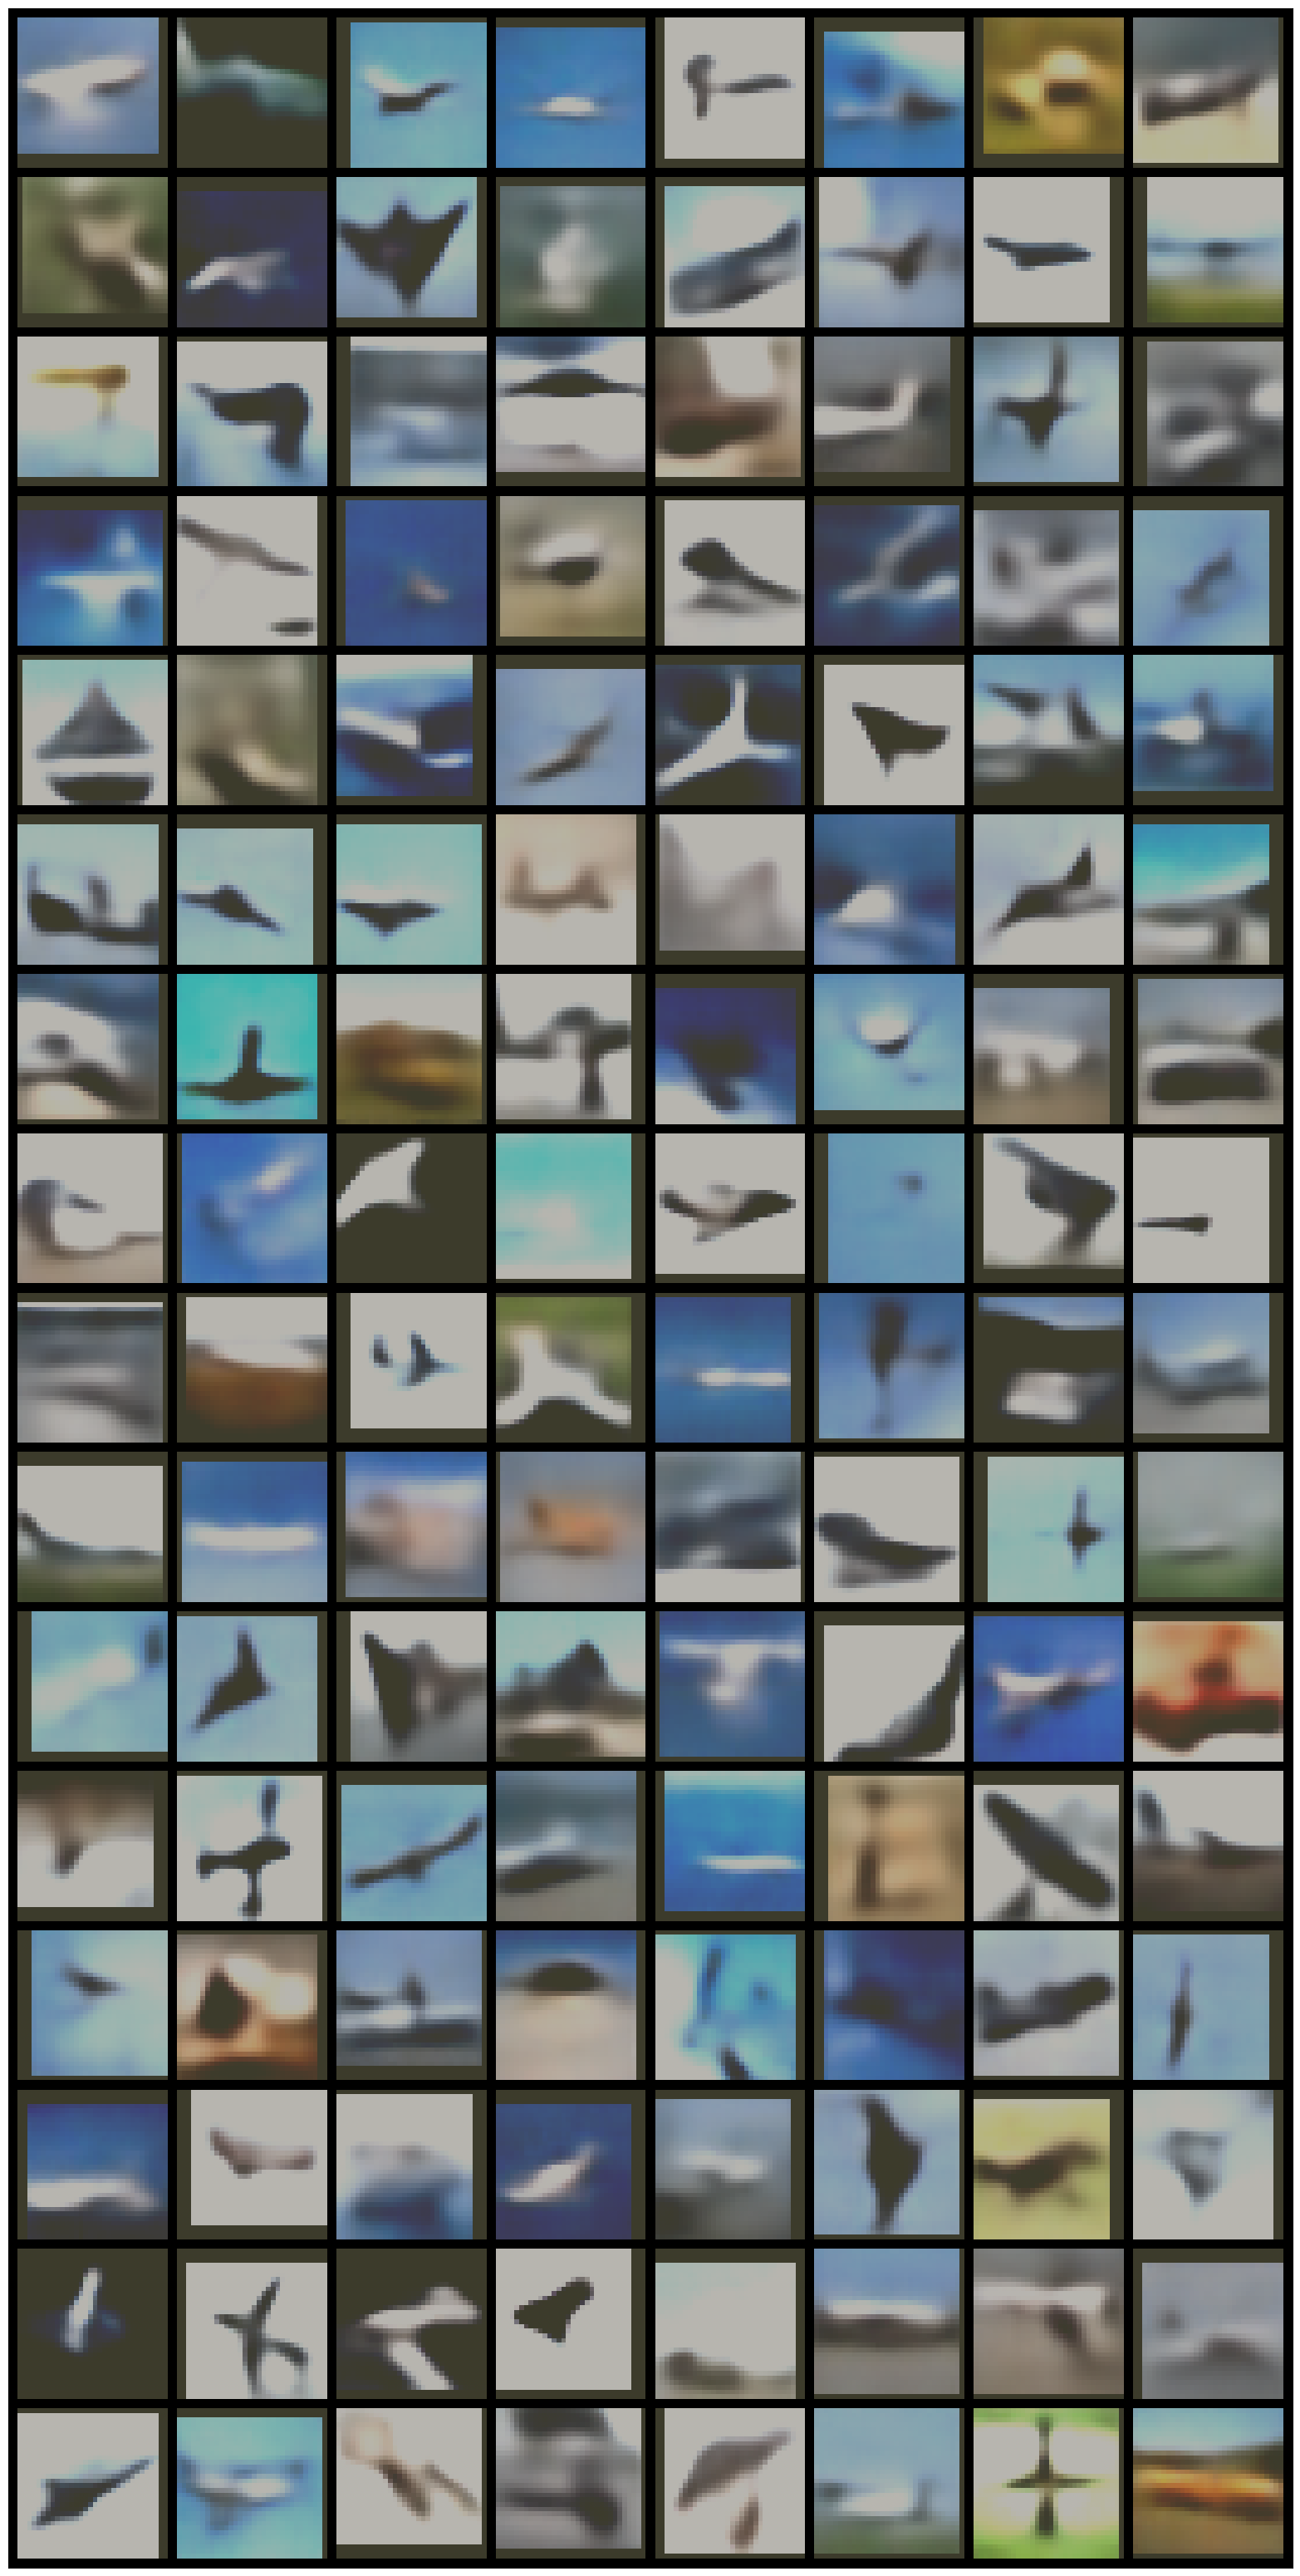

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

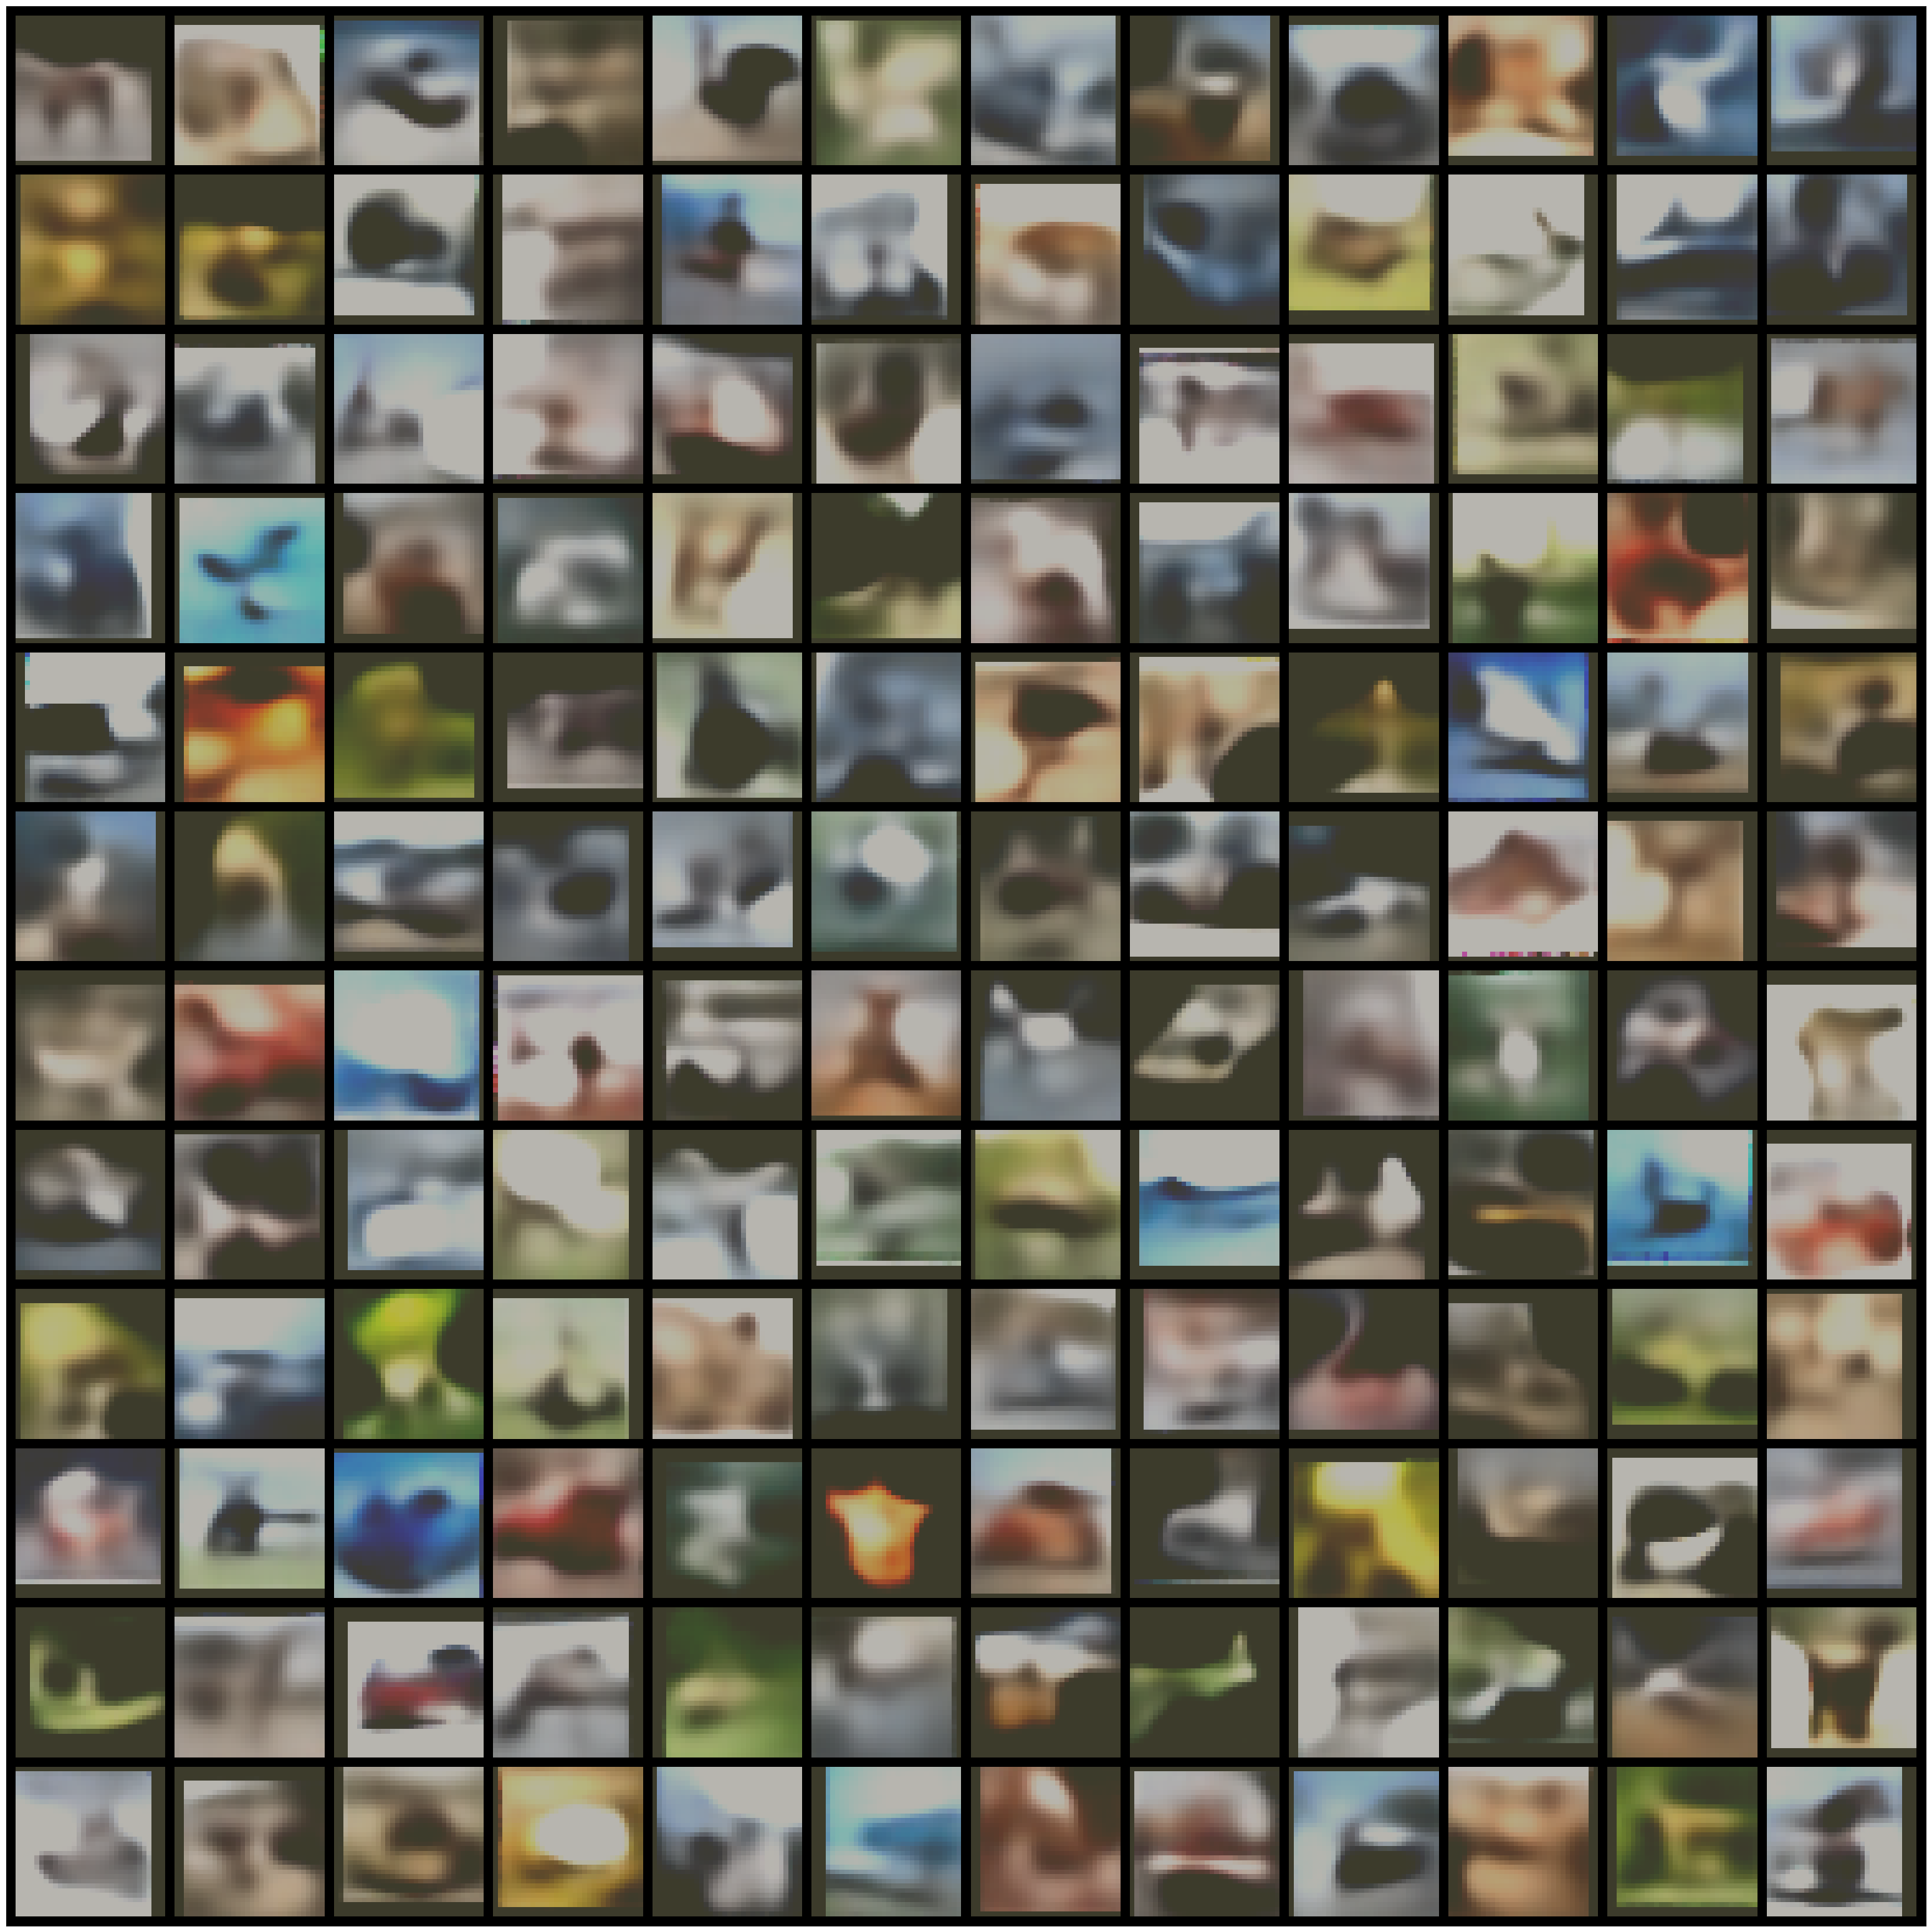

In [11]:
z = torch.randn(144, 512).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)